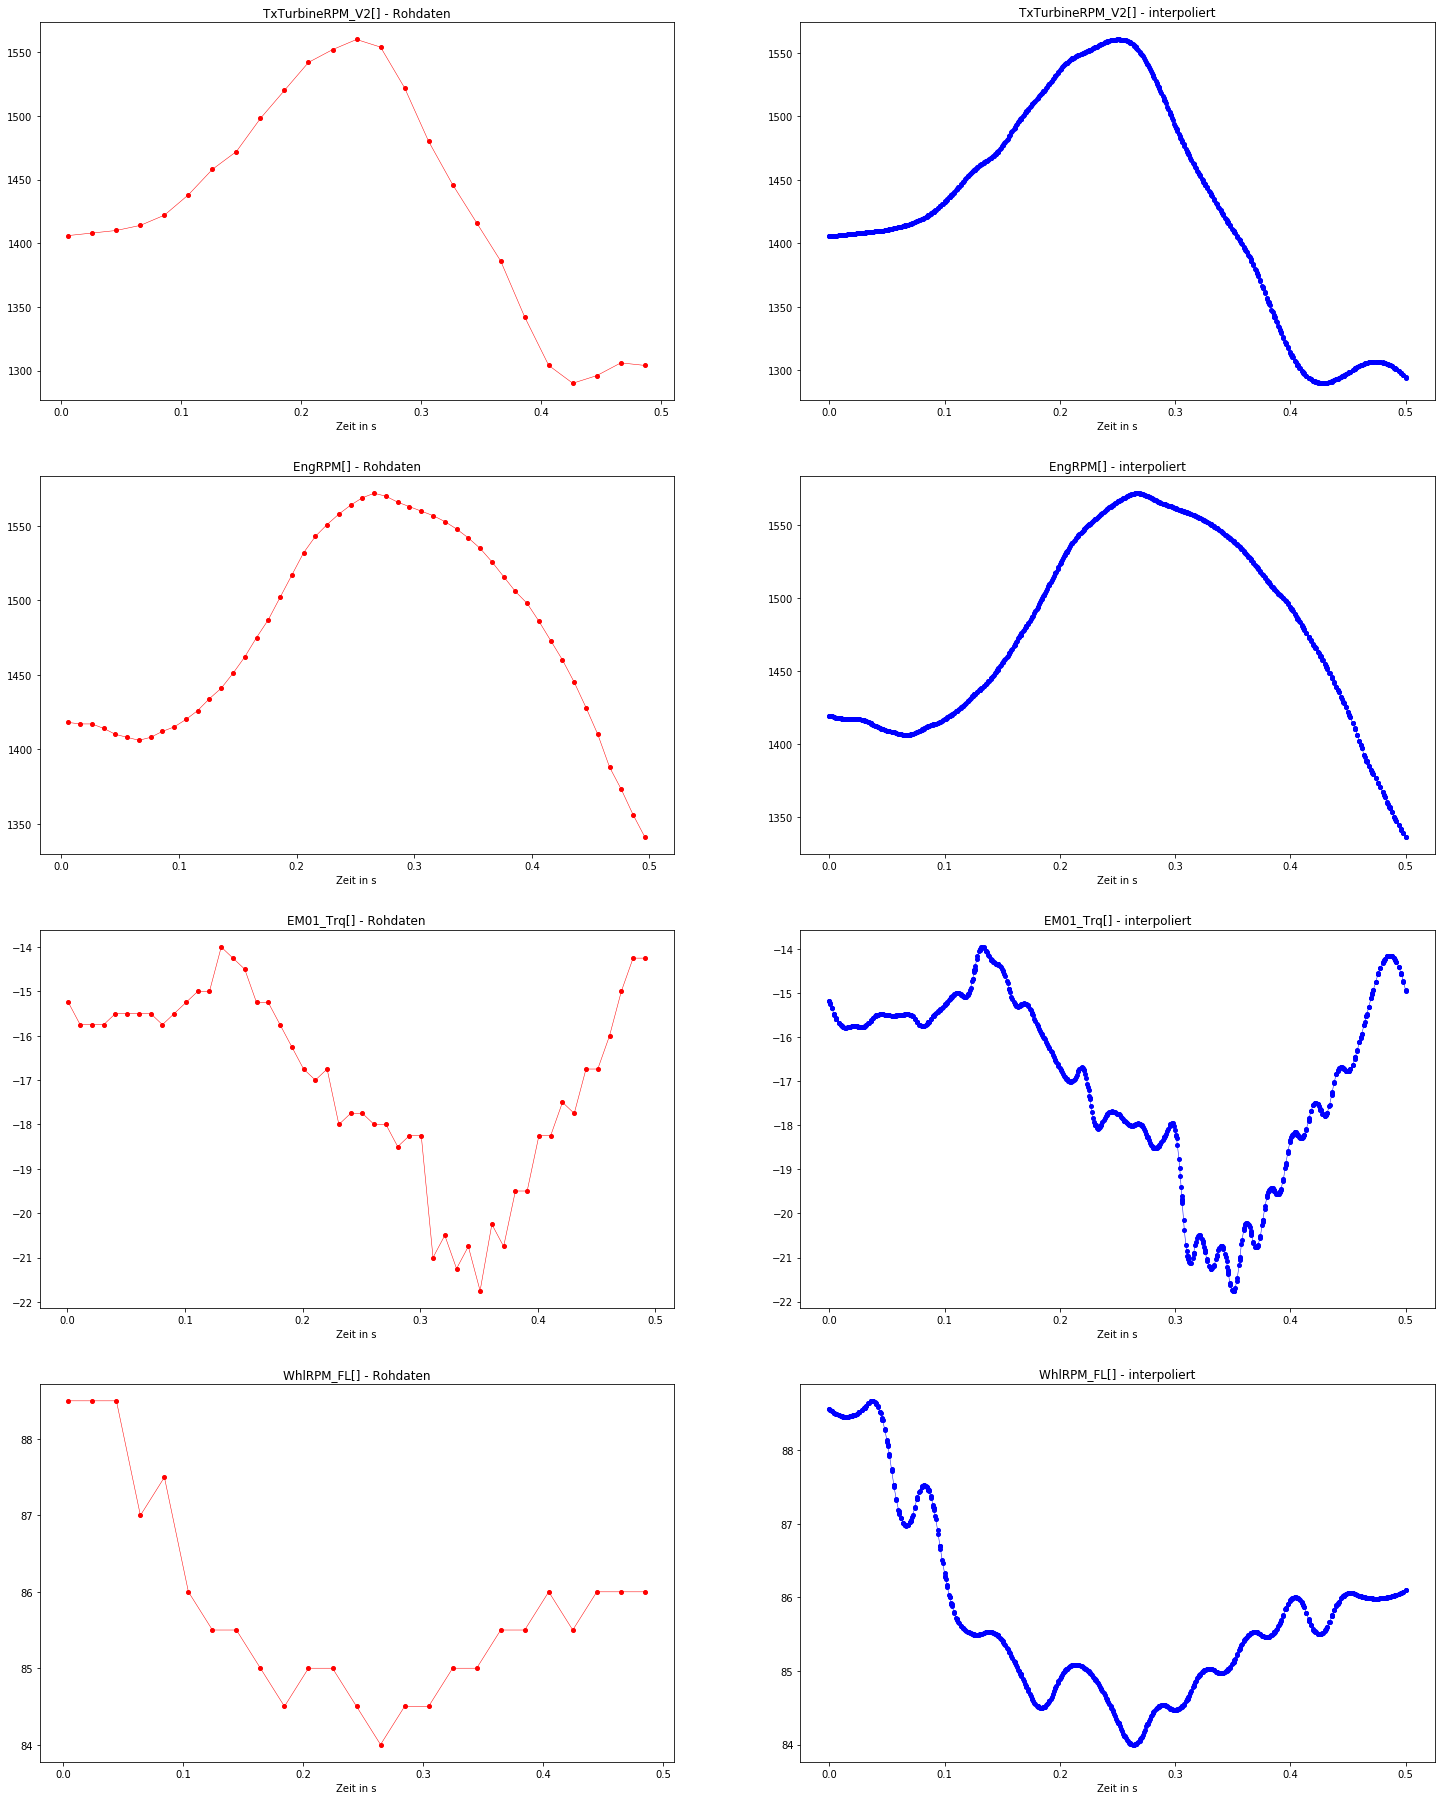

In [18]:
from PyQt5.QtWidgets import QMainWindow, QPushButton, QLabel, QWidget
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt



import sys
from PyQt5 import QtWidgets
from PyQt5 import QtCore
#------------------------------------------------------------------------------
# =============================================================================
# Ladefenster ließt Name und Pfad auf Variable self.dateiname, welcher später 
#mit behehl pd.read_excel zum lesen der Datei verwendet wird.
#funktion set_grafisch setzt variable self.grafisch auf wahr oder falsch.
#Diese wird verwendet um später zu entscheiden ob eine grafische Auswertung vollzogen wird 
# =============================================================================
class LadeFenster(QWidget):
    def __init__(self): 
        super().__init__()
               
        self.setGeometry(350,350,700,350)
        self.setWindowTitle('Ladedialog')
        
        self.l = QtWidgets.QLabel(self)
        self.l.setGeometry(QtCore.QRect(160, 20, 551, 51))
        self.l.setText('Bitte wählen Sie eine Datei die Sie bearbeiten wollen und drücken Sie anschließend auf "Weiter"')
        
        self.textBrowser_2 = QtWidgets.QTextBrowser(self)
        self.textBrowser_2.setGeometry(QtCore.QRect(160, 60, 451, 40))

        self.label = QtWidgets.QLabel(self)
        self.label.setText("Ausgewählte Datei:")
        self.label.setGeometry(QtCore.QRect(60, 60, 101, 31))

        self.r1 =QtWidgets.QRadioButton(self) # radiobutton für Auswahl "Nur Interpolieren"
        self.r1.setChecked(True)
        self.r1.setGeometry(QtCore.QRect(60,160,18,18))#
        self.r1.toggled.connect(self.set_grafisch)
        
        self.l1 = QtWidgets.QLabel(self)
        self.l1.setGeometry(QtCore.QRect(80, 153, 551, 30))
        self.l1.setText('Ich möchte nur Daten interpolieren')
        
        self.r2 =QtWidgets.QRadioButton(self)# radiobutton für Auswahl "mit grafischer Ausertung"
        self.r2.setObjectName('r2')    
        self.r2.setGeometry(QtCore.QRect(60,220,18,18))
        self.r2.toggled.connect(self.set_grafisch)
        
        self.grafisch = False# Variable zur Programmsteuerung, besagt ob Nuetzer grafische Auwertung wollte oder nicht
        
        self.l2 = QtWidgets.QLabel(self)
        self.l2.setGeometry(QtCore.QRect(80, 213, 551, 30))
        self.l2.setText('Ich möchte Daten interpolieren und grafisch ausgewertet bekommen')
        
        button = QtWidgets.QPushButton(" Weiter" , self)
        button.setGeometry(QtCore.QRect(540, 280, 75, 23))
        button.clicked.connect(self.close)
        
        button2 = QPushButton('Durchsuchen', self)
        button2.setGeometry(QtCore.QRect(160, 100, 121, 23))
        button2.clicked.connect(self.laden)#
                
        self.show()
        
    def set_grafisch(self): # veränder variable self.grafisch je nach Auswahl
        if self.r1.isChecked():
            self.grafisch = False
        elif self.r2.isChecked():
            self.grafisch = True

        
    def laden(self):#
        self.dateiname = str(QtWidgets.QFileDialog.getOpenFileName(self, 'Datei öffnen', 'C:\\')[0])# schreibt name und Pfad der ausgewählten datei auf Variable
        self.textBrowser_2.clear()
        self.textBrowser_2.append(self.dateiname)# gibt dateiname im Textbrowser aus

app = QtCore.QCoreApplication.instance() # Pointer für Application instanz

if app is None:# Fix zur Behebung von Problem mit Fensteraufruf (stürzt sonst jedes 2. mal ab)
    app = QtWidgets.QApplication(sys.argv)
    
Lade = LadeFenster() # erstellung einer instanz der Klasse LadeFenster

app.exec_()      # ausführung der Apllikation   
#------------------------------------------------------------------------------
#gewählte datei wird eingelesen als DataFrame
df = pd.read_excel(Lade.dateiname)
# =============================================================================
#anhand des Dataframes wird die Klasse Tabelle erstellt.
#Nach der Initiation ließt Sie alle Spalten ein. Spalte 1 ist dabei sel.zeit
# =============================================================================

class tabelle:
    def __init__(self, df):
        self.laenge = self.laenge_auslesen(len(df)-1)#länge der Tabelle wird über funktion laenge_auslesen ausgelesen
        self.spalte= [] # Liste auf die später alle Spalten gelesen werden
        self.eintraege = [] # liste welche die Summen der jeweiligen Spalten beinhaltet
        
        for i in range(0,len(df.columns)):# beschreibung von self.spalte und self. eintraege
           self.spalte.append(df.iloc[:self.laenge +1,i])
           self.eintraege.append(self.laenge - self.spalte[i].isna().sum())
           
        self.zeit = self.spalte[0] # zeitspalte wird gesondert auf Variable abgelegt
        self.zeit_genullt = self.zeit - self.zeit[0] # spalte mit der Zeit, wobei Werte so verschoben wurden , das erster Wert bei 0s ist

        self.zeit_schritt_max = 0    # erstellt Variable für minimum und Maximum der Abstände der einzelnen Zeitpunkte, diese werden in Schleife darunter ausgelesen
        self.zeit_schritt_min = 1000        
        for i in range(1,len(self.zeit)):# ließt maximale und minimale Schrittweite zwischen zwei Zeitdatenpunkten aus
            if (self.zeit[i] -self.zeit[i-1]) > self.zeit_schritt_max:
                self.zeit_schritt_max = (self.zeit[i] -self.zeit[i-1])
            if (self.zeit[i] -self.zeit[i-1]) < self.zeit_schritt_min:
                self.zeit_schritt_min = (self.zeit[i] -self.zeit[i-1])
        
        
    def laenge_auslesen(self,pos):# liest länge der Datespalte (Zeit aus)
        if isinstance(df.iloc[pos,0],float) == False:# schaut ob wert in letzter zeile der Spalte ein float Wert ist
            return self.laenge_auslesen(pos - 1)# wenn nicht geht er in Zeile darüber und und wiederholt den Vorgang
        else: 
            return pos# wenn doch gibt er Position der Zeile zurück
        

    def zeit_zuordnen(self, spalten_index , anfang = 0 , ende = 0, genullt = False):#Ordnet der Spalte mit Index "spalten_index"(eingabewert) für alle vorhandenen Werte einen Zeitwert zu
        if ende == 0:
            ende = len(self.zeit[self.spalte[spalten_index].notnull()])# wenn nicht anders angegeben werden allen in der jeweiligen Spalte vorhandenen Daten eine Zeit zugeordnet
        zeit_gefiltert = self.zeit[self.spalte[spalten_index].notnull()]# Vektor mit allen Zeitpunkten bei denen in Spalte mit Index "spalten_index" werte vorhanden sind
        if genullt == True:#gibt verschiedene Werte aus je nachdem zeit genullt, oder der Zeitbereich verändert wurde(siehe self.genullt und self.erweitert von MainWindow)
            zeit_gefiltert = zeit_gefiltert - self.zeit[0]
        return zeit_gefiltert[(zeit_gefiltert >= anfang) & (zeit_gefiltert <= ende)]

    
    def filtern(self, spalten_index, anfang = 0, ende = 0 , genullt = False):#gibt für eingelesene Spalte mit Index "Spaltenindex", von "anfang" bus "ende" alle vorhandenen Daten aus (keine leeren Einträge)

        if ende == 0:
            ende = len(self.zeit[self.spalte[spalten_index].notnull()])        
        spalte_gefiltert = self.spalte[spalten_index][self.zeit_zuordnen(spalten_index, anfang, ende, genullt).index]# mit der fubktion "zeit_zuordnen" und .index(), werden alle Indexe geholt, für welche die jeweilige Spalte Daten besitzt    
        return spalte_gefiltert

#------------------------------------------------------------------------------
spaltenzahl = len(df.columns)# anzahl spalten
tab = tabelle(df)# definiert tab als instanz der Klasse Tabelle
# =============================================================================
# Fenster mit Tabelle einiger ausgelesener Daten (eigentlich nich so spannend)
# Instanz von Tabellenfenster wird später als Objekt von Hauptfenster aufgerufen
# =============================================================================
class TabellenFenster(QWidget):

    def __init__(self):
        super().__init__()
       
        self.setGeometry(0,10,50 + (spaltenzahl) * 94 + 160,150)
        self.ueberschrift = QtWidgets.QLabel(self)
        self.ueberschrift.setGeometry(QtCore.QRect(30, 20, 551, 31))
        self.ueberschrift.setText("Eingelesene Daten")
        
        self.hbox = QtWidgets.QHBoxLayout()
        
        self.tabelle = QtWidgets.QTableWidget()
        self.tabelle.setRowCount(3)
        self.tabelle.setColumnCount(spaltenzahl)
        self.tabelle.setHorizontalHeaderLabels(df.columns)
        self.tabelle.setVerticalHeaderLabels(['Startwert:', 'Endwert:' , 'Datenpunkte', 'Verteilung'])

        self.hbox.addWidget(self.tabelle)
        self.tabelle.setItem(0,0,QtWidgets.QTableWidgetItem(str(df.columns[0])))   
            
        for spalte in range (0,spaltenzahl):# erstellt für alle eingelesenen Spalten Werte für startwert Endwert und Anzahl Datenpunkt(in dieser Reihenfolge)
            Daten = tab.filtern(spalte).reset_index(drop = True) # schreibt für jede Spalte alle vorhandenen einträge auf Variable Spalten über Funktion "filtern" (siehe oben)                       
            self.tabelle.setItem(0,spalte,QtWidgets.QTableWidgetItem(str(Daten[0])[:7]))
            self.tabelle.setItem(1,spalte,QtWidgets.QTableWidgetItem(str(Daten[len(Daten)-1])[:7]))
            self.tabelle.setItem(2,spalte,QtWidgets.QTableWidgetItem(str(len(Daten))[:7]))
            
           
        self.setLayout(self.hbox)     
        self.show()


# =============================================================================
# Im HauptFenster kann folgendes entschieden werden:
#    - welche Datensätze(spalten) sollen verarbeitet werden.
#    Dazu werden Checkboxen und Label mit Namen der Spalten dynamisch generiert
#    
#    - Zeitachse kann genullt werden und Anfangs- und Endwert des Zeitintervalls kann festgelegt werden
#    !!!Achtung: angegebenes Zeitintervall muss innerhalb der Grenzen liegen, die beim Betätigen der Knöpfe
#    Zeit nullen und Reset erscheinen!!!
#    
#    -Interpolation erfolgt standartmäßig für alle vorhandenen und im Zeitintervall vorhandenen Datenpunkte
#      zusätzliche Datenpunkte der Zeit können im ausgewählten Abstand generiert werden
    
# =============================================================================
    

class HauptFenster(QMainWindow):
    
    def __init__(self):# erbt von QMainWindow, hier werden sämtliche Knöpfe; Textfelder usw. aufgebaut
        super().__init__()

        self.setGeometry(600,240,550,50 + (spaltenzahl) * 45)
        
        self.l = QLabel(self )
        self.l.setText('Wie sollen die Daten verarbeitet werden?')
        self.l.setGeometry(20,120,250,30)
        
        self.l1 = QLabel(self )
        self.l1.setText('Welche Datenssätze sollen verarbeitet werden?')
        self.l1.setGeometry(300,120,250,30)
        
        self.erweitert =False# Variable zur Ablaufsteuerung, gibt an ob zusätzliche Zeitwerte generiert werden sollen
        
        for i in range (1,spaltenzahl):# Checkboxen und Namen der gefundenen Datensätze/Spalten in Tabelle (außer Zeitspalte), werden erstellt
                
            self.cb = QtWidgets.QCheckBox(self)
            self.cb.setGeometry(420,160 + (i-1)*25,20,20)
            self.cb.setObjectName(str(i))
            self.cb.setChecked(True)
            self.l = QtWidgets.QLabel(self)
            self.l.setText(df.columns[i])
            self.l.setGeometry(QtCore.QRect(300, 155 + (i-1)*25,120,25))

        button = QtWidgets.QPushButton(" Weiter" , self)
        button.move(400, spaltenzahl * 45)
        button.clicked.connect(self.weiter)
        
        self.zeit0 = QtWidgets.QRadioButton(self)#m radiobutton zur auswahl der "zeit_nullen" funktion
        self.zeit0.setGeometry(QtCore.QRect(110, 222 ,20,20))
        self.zeit0.toggled.connect(self.zeit_nullen)
        
        self.resetbut = QtWidgets.QRadioButton(self)# radiobutton der Zeitbereich auf ursprungswerte zurücksetzt
        self.resetbut.setGeometry(QtCore.QRect(110, 248 ,20,20))
        self.resetbut.toggled.connect(self.reset)
        
        self.zeit0_reset = QtWidgets.QButtonGroup(self)# Buttongroup in welche die beiden oberen Button zugeordnet werden, ohne ButtonGroups könnte sonst immer nur einer der 4 Radiobutton angewählt werden
        self.zeit0_reset.addButton(self.zeit0)
        self.zeit0_reset.addButton(self.resetbut)  
        
        self.lzeit = QtWidgets.QLabel(self)
        self.lzeit.setText('Zeitachse nullen: \n\n\tReset: ')
        self.lzeit.setGeometry(QtCore.QRect(20, 220 ,85,45))
        
        self.schritt = QtWidgets.QLabel(self)# Label zur Angabe des maximalen und minimalen Zeitschritts
        self.schritt.setText('Abstände der Datenpunkte in der Zeitachse [ms]:\n\nMinimum: ' + str("{:.5f}".format(tab.zeit_schritt_min*1000)) + ' ms\nMaximum: ' +str("{:.5f}".format(tab.zeit_schritt_max*1000)) + ' ms')
        self.schritt.setGeometry(QtCore.QRect(20,10,250,100))
        
        self.zeitbereich = QtWidgets.QLabel(self)
        self.zeitbereich.setText('Zeitbereich in s:\nStart [s]\t\tEnde [s]')
        self.zeitbereich.setGeometry(QtCore.QRect(20, 150 ,200,50))
        
        self.a = QtWidgets.QLineEdit(self)# Ein und Ausgabefenster für den Anfangswert des gewählten Zeitbereichs
        self.a.setObjectName('a')
        self.a.setText(str("{:.5f}".format(tab.zeit[0])))
        self.a.setGeometry(QtCore.QRect(20, 195 ,65,25))
        
        self.e = QtWidgets.QLineEdit(self)# für ende des Zeitbereichs
        self.e.setObjectName('e')
        self.e.setText(str("{:.5f}".format(tab.zeit[len(tab.zeit) - 1])))
        self.e.setGeometry(QtCore.QRect(110, 195 ,65,25))
        

        self.r1= QtWidgets.QRadioButton(self)# r1 und r2 sind radiobutton mit denen ausgeählt wird ob zusätzliche Zeitdaten generiert werden solle
        self.r1.setGeometry(QtCore.QRect(215,310,40,20))
        self.r1.setChecked(True)
        
        self.r2= QtWidgets.QRadioButton(self)
        self.r2.setGeometry(QtCore.QRect(215,335,40,20))
        self.r2.toggled.connect(self.auswahl_an_aus)
        
        self.zeitdaten = QtWidgets.QButtonGroup(self)# buttongroup der darüber stehenden radiobutton
        self.zeitdaten.addButton(self.r1)
        self.zeitdaten.addButton(self.r2)
        
        self.zl = QtWidgets.QLabel(self)
        self.zl.setText('Interpolation:\n\nNur existierende Zeitdaten verwenden: \n\nZusätliche Zeitdaten generieren: ')
        self.zl.setGeometry(QtCore.QRect(20,277,200,80))
        
        self.lausw = QtWidgets.QLabel(self)
        self.lausw.setText('Welche Auflösung sollen die generierten\nZeitdaten haben?')
        self.lausw.setGeometry(QtCore.QRect(20,370,200,30))
        
        self.ausw = QtWidgets.QLineEdit(self)
        self.ausw.setGeometry(QtCore.QRect(20,400,200,30))
        self.ausw.setEnabled(False)
        
        self.ms = QtWidgets.QLabel(self)
        self.ms.setText('ms')
        self.ms.move(230,402)
        
        self.show()
        
        self.w = TabellenFenster()# ersschafft instanz des vorher definierten Tabellenfensters
        self.w.show()# lädt Tabellenfenster
        
    def zeit_nullen(self):# setzt angezeigten End- und Anfangswert der Zeitachse, so dass Zeitintervall bei 0 beginnt
        if self.zeit0.isChecked():
            self.a.setText(str("{:.5f}".format(tab.zeit_genullt[0])))
            self.e.setText(str("{:.5f}".format(tab.zeit_genullt[len(tab.zeit)-1])))
            

    def reset(self):  # setzt angezeigten End- und Anfangswert der Zeitachse auf ursprüngliche Werte      
        if self.resetbut.isChecked() == True:
            self.a.setText((str("{:.5f}".format(tab.zeit[0]))))
            self.e.setText(str("{:.5f}".format(tab.zeit[len(tab.zeit)-1])))
            
    def auswahl_an_aus(self):# gibt Eingabefeld für zusätzliche Erstellung von Datenpunkten in der Zeitachse frei oder sperrt es, je nach auswahl
        self.ausw.setEnabled(self.r2.isChecked())
        if self.r1.isChecked():
            self.ausw.clear()
            
    def komma_weg(self,eingabe):# entfernt komma(falls vorhanden) aus eingabefelden, ersetzt es mit Punkt und gibt eingegebenen Wert im float Format zurück
         if ',' in eingabe:
            eingabe = eingabe.replace(',','.')
         return float(eingabe)
        
        
    def weiter(self):# erstellt anhand der Eingaben Variabeln, die später zur Berechnung oder Programmsteuerung dienen
        if (self.r2.isChecked() & (self.ausw.text() != "")):
            self.aufl = self.komma_weg(self.ausw.text())/1000
            self.erweitert = True# gibt an, dass zusätzliche Zeitdaten generiert werden sollen (wenn  True)
        if self.zeit0.isChecked():
            self.genullt = True # gibt an ob Zeitintervall genullt werden soll oder nich
        else:
            self.genullt = False

        self.anfang = self.komma_weg(self.a.text())# schreibt den eingegebenen anfangs und Endwert des Zeitintervalls auf 2 Variablen
        self.ende = self.komma_weg(self.e.text())

        self.Auswahl = []# schreibt Liste mit Einträgen True oder False, anhand der (über die Checkboxen) ausgewählten Datensätze
                    # damit wird später entschieden welche Datensätze (Spalten)  verarbeitet werden und welche nicht
        for i in range (1,spaltenzahl):
            self.Auswahl.append(self.findChild(QtWidgets.QCheckBox, str(i)).isChecked())


        self.w.close()# schließt Tabellenfenster
        self.close()# schließt sich selbst

app = QtCore.QCoreApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)

w = HauptFenster()# instanz des Hauptfensters
w.show()
app.exec_()
# =============================================================================
# erstellt DataFrame "ausgabe" mit den Daten der zu erstellenden excel Tabelle
# erstellt Plot wenn ausgewählt
# =============================================================================



if Lade.grafisch == True:
    nummer_grafik = 0# für position des subplots in Figure
    zeile_grafik = len([i for i in w.Auswahl if i==True])# anzahl der Zeilen der grafik, ausgelesen aus anzahl der ausgewählten Datensätze
    f = plt.figure(figsize = (25,zeile_grafik * 8))# erstellt figure Objeckt in Größe die von anzahl der Datensätze abhängig ist
    
erstbeschreibung = True# damit beim schleifendurchlauf die erste Zeile die spalte mit zeitdaten wird
for i in range(1,spaltenzahl):# geht alle Spalten durch (außer Zeitspalte)
    
    if w.Auswahl[i-1]:# prüft ob jeweilige Spalte vom Nutzer im Hauptfenster ausgewählt wurde
        x = np.array(tab.zeit_zuordnen(i,w.anfang,w.ende, w.genullt), dtype = float)# array mit zeitdaten die den aktuell verarbeiteten Datensatz zugeordnet werden
        y = np.array(tab.filtern(i,w.anfang,w.ende,w.genullt), dtype = float)# alle vorhandenen Daten des aktuellen Datensatzes
        
        if w.genullt == True:# xneu: zeitachse für die Interpolation, wird erstellt, je nachdem ob sie genullt werden sollte und ob weitere Zeitdaten erstellt wurden
            xneu= np.array(tab.zeit_genullt[(tab.zeit_genullt >= w.anfang) &(tab.zeit_genullt <= w.ende)], dtype = float)
        else:
            xneu= np.array(tab.zeit[(tab.zeit >= w.anfang) &(tab.zeit <= w.ende)], dtype = float)
            
        if w.erweitert == True:# erstellt ggf. Vektor mit neuen Zeitdaten, hängt diesen an existierende Zeitdaten und ordnet nach Wert
            xneu = np.append(xneu, np.linspace(w.anfang,w.ende,round((w.ende-w.anfang)/w.aufl)))
            xneu = np.sort(xneu)
            
        if erstbeschreibung == True:# schreibt im ersten Durchlauf dien Zeitachse auf DatFrame
            ausgabe = np.transpose(pd.DataFrame([xneu], index = [df.columns[0]]))
            erstbeschreibung = False
            
        intfunk = interpolate.interp1d(x,y,kind = 'quadratic', fill_value="extrapolate")# definiert die Interpolationsfunktion mit den aus der Tabelle ausgelesenen Daten
        interpol_daten =intfunk(xneu)# inetrpoliert die Daten auf neue Zeitachse
        ausgabespalte= np.transpose(pd.DataFrame([interpol_daten], index = [df.columns[i]]))#schreibt interpolierte Daten des aktuellen Datensatzes auf DataFrame
        ausgabe = pd.concat([ausgabe, ausgabespalte], axis = 1)# verknüpft die aktuelle spalte/Datensatz mit den in vorherigen durchläufen erstellten, zu einem DataFrame
        
        if Lade.grafisch == True:  # erstellt den Plot                       
            plt.subplot(zeile_grafik,2,1 + 2* (nummer_grafik))# Plot mit ausgelesenen Daten
            plt.title(df.columns[i] + ' - Rohdaten')
            plt.xlabel('Zeit in s')
            plt.plot(tab.zeit_zuordnen(i,w.anfang,w.ende, w.genullt), tab.filtern(i,w.anfang,w.ende,w.genullt),lw= 0.5, c = 'r', marker = 'o', ms = 4)
            
            plt.subplot(zeile_grafik,2,2 + 2* (nummer_grafik))# Plot mit interpolierten Date
            plt.title(df.columns[i] + ' - interpoliert')
            plt.xlabel('Zeit in s')
            plt.plot(xneu,interpol_daten,lw = 0.5, c = 'b' ,marker = 'o', ms = 4)
            nummer_grafik += 1

# =============================================================================
##Fenster zum Speichern
# =============================================================================
class SpeicherFenster(QWidget):
    def __init__(self): 
        super().__init__()
                
        self.setGeometry(350,350,700,250)
        self.setWindowTitle('Speicherdialog')
        
        self.textBrowser = QtWidgets.QLabel(self)
        self.textBrowser.setGeometry(QtCore.QRect(60, 30, 551, 51))
        self.textBrowser.setObjectName("textBrowser")
        self.textBrowser_2 = QtWidgets.QTextBrowser(self)
        self.textBrowser.setText('Wo möchten Sie die Dateien speichern?')
        self.textBrowser_2.setGeometry(QtCore.QRect(160, 140, 451, 31))
        self.textBrowser_2.setObjectName("textBrowser_2")
        self.label = QtWidgets.QLabel(self)
        self.label.setText("Speicherort:")
        self.label.setGeometry(QtCore.QRect(60, 140, 101, 31))
        self.label.setObjectName("label")
        button = QtWidgets.QPushButton(" Fertig" , self)
        button.setGeometry(QtCore.QRect(540, 180, 75, 23))
        button.clicked.connect(self.close)
        button2 = QPushButton('Datei Speichern', self)
        button2.setGeometry(QtCore.QRect(160, 180, 121, 23))

        button2.clicked.connect(self.speichern)#
             
        self.show()
        
    def speichern(self):#schreibt ausgewählten Dateiname - und Pfad in Textfenster und auf die Variable self.ausgabename(zur späteren verwendung) 
        self.ausgabename = QtWidgets.QFileDialog.getSaveFileName(self)[0]
        self.textBrowser_2.clear()
        
        if '.' in self.ausgabename:# in dieser Verzweigung werden evtl. angefügt Dateiendungen(wie .xlsx) wieder entfernt, da diese später automatisch angehangen werden
            ind = -self.ausgabename.rfind('.')
            self.ausgabename = self.ausgabename[:ind - 1]
        self.textBrowser_2.setText(str(self.ausgabename))

     

app = QtCore.QCoreApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
Speicherfenster = SpeicherFenster()
app.exec_()

# =============================================================================
#speichert den erstellten DataFrame als excel Tabelle, sowie den Plot (wenn erstellt) als .png datei
# =============================================================================

name=Speicherfenster.ausgabename
if Lade.grafisch == True:
    plt.savefig(name + '.png')
ausgabe.to_excel(name + '.xlsx', index = False)



